# Assignment 1: This is the title of the assignment

Authors:  
Lina Hagberg  
Ella Villför  

## Imports

ToDo: 
* Rensa bland viderona 
* Dela upp i träning 
* .MOV funkar ej

In [ ]:
# It is recommended to start with general import statements
from utility_functions import *
import ultralytics
ultralytics.checks()
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split


In [ ]:
num_keypoints = 17 * 2  # 17 keypoints 34 total value
num_frames = 150 # Ca 4-5 seconds

## Load data

This section should load the raw dataset for the task.  
Remember to use relative paths to load any files in the notebook.

In [ ]:
# 200 !
# Data to calssify: barbell biceps curl, bench press, deadlift, plank, pull up, push up, shoulder press and squat

# Load the YOLOv8 model
model = YOLO('yolov8n-pose.pt', verbose=False)

# Path to the main dataset folder
dataset_path = "raw_data" 
output_csv = "keypoints_dataset.csv"
num_keypoints = 17 * 2  # 17 keypoints 34 total value
num_frames = 200

X = []
Y = []

# Iterate over each subfolder (exercise category)
for exercise_folder in os.listdir(dataset_path):
    if exercise_folder == ".DS_Store":
        continue
    
    exercise_path = os.path.join(dataset_path, exercise_folder)
    print(f"Processing: {exercise_path}")

    
    # Ensure it's a directory
    if not os.path.isdir(exercise_path):
        continue
    
    # Iterate over each video in the exercise folder
    for video_file in os.listdir(exercise_path):
        video_path = os.path.join(exercise_path, video_file)
        
        # Ensure it's a video file (basic check)
        if not video_file.lower().endswith((".mp4", ".mov")):
            continue
        
        cap = cv2.VideoCapture(video_path)
        keypoints_list = []

        # Loop through the video frames
        while cap.isOpened():
            # Read a frame from the video
            success, frame = cap.read()

            if not success:
                break

            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True, tracker ='bytetrack.yaml', conf=0.05, classes=0, verbose=False)

            # Extract keypoints (Handle cases where no person is detected)
            if results[0].keypoints is not None:
                # Takes the most confident person (fisrt person in list)
                keypoints = results[0].keypoints.xy.cpu().numpy()[0].flatten()
            else:
                keypoints = np.zeros(num_keypoints)  # Fill with zeros if no keypoints detected

            # Ensure keypoints are always 34 values
            if len(keypoints) > num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}. Only keeping 34 first - {video_file}")
                keypoints = keypoints[:num_keypoints]  # Trim to match expected length
                
            elif len(keypoints) < num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}.Filling with zeros - {video_file}")
                keypoints = np.pad(keypoints, (0, num_keypoints - len(keypoints)), 'constant')

            # Append to DataFrame
            keypoints_list.append(keypoints)

        cap.release()

        keypoints_list = np.array(keypoints_list)
        
        if len(keypoints_list) < num_frames:
            # Padding
            keypoints_list_adj = np.pad(keypoints_list, ((0, num_frames - keypoints_list.shape[0]), (0, 0)),  'constant')

            #keypoints_list = np.pad(keypoints_list, (0, num_frames - len(keypoints_list)), 'constant')
        elif len(keypoints_list) > num_frames:
            # Trim
            keypoints_list_adj = keypoints_list[:num_frames]
            
        X.append(keypoints_list_adj)
        Y.append(exercise_folder)

        if exercise_folder == "plank" and keypoints_list.shape[0] > num_frames*2:
            keypoints_list_adj = keypoints_list[keypoints_list.shape[0]-num_frames:keypoints_list.shape[0]]
            X.append(keypoints_list_adj)
            Y.append(exercise_folder)



# Convert to NumPy arrays
X_numpy = np.array(X)  # Shape: (num_videos, 200, 34)
Y_numpy = np.array(Y)  # Labels

print(f"Shape X: {X_numpy.shape}")  # Should be (num_videos, 200, 34)
print(f"Shape Y: {Y_numpy.shape}")  # Should be (num_videos,)


In [ ]:
# 150 !
# Load the YOLOv8 model
model = YOLO('yolov8n-pose.pt', verbose=False)

# Path to the main dataset folder
dataset_path = "raw_data" 
output_csv = "keypoints_dataset.csv"
num_keypoints = 17 * 2  # 17 keypoints 34 total value
num_frames = 150 # Ca 4-5 seconds

X = []
Y = []

# Iterate over each subfolder (exercise category)
for exercise_folder in os.listdir(dataset_path):
    if exercise_folder == ".DS_Store":
        continue
    
    exercise_path = os.path.join(dataset_path, exercise_folder)
    print(f"Processing: {exercise_path}")

    
    # Ensure it's a directory
    if not os.path.isdir(exercise_path):
        continue
    
    # Iterate over each video in the exercise folder
    for video_file in os.listdir(exercise_path):
        video_path = os.path.join(exercise_path, video_file)
        
        # Ensure it's a video file (basic check)
        if not video_file.lower().endswith((".mp4", ".mov")):
            continue
        
        cap = cv2.VideoCapture(video_path)
        keypoints_list = []

        # Loop through the video frames
        while cap.isOpened():
            # Read a frame from the video
            success, frame = cap.read()

            if not success:
                break

            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True, tracker ='bytetrack.yaml', conf=0.05, classes=0, verbose=False)

            # Extract keypoints (Handle cases where no person is detected)
            if results[0].keypoints is not None:
                # Takes the most confident person (fisrt person in list)
                keypoints = results[0].keypoints.xy.cpu().numpy()[0].flatten()
            else:
                keypoints = np.zeros(num_keypoints)  # Fill with zeros if no keypoints detected

            # Ensure keypoints are always 34 values
            if len(keypoints) > num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}. Only keeping 34 first - {video_file}")
                keypoints = keypoints[:num_keypoints]  # Trim to match expected length 
                
            elif len(keypoints) < num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}.Filling with zeros - {video_file}")
                keypoints = np.pad(keypoints, (0, num_keypoints - len(keypoints)), 'constant')

            # Append to DataFrame
            keypoints_list.append(keypoints)

        cap.release()

        keypoints_list = np.array(keypoints_list)

        # Section video to lenght num_frames
        if len(keypoints_list) < num_frames:
            # Padding
            keypoints_list_adj = np.pad(keypoints_list, ((0, num_frames - keypoints_list.shape[0]), (0, 0)),  'constant')
            X.append(keypoints_list_adj)
            Y.append(exercise_folder)

        elif len(keypoints_list) > num_frames:
            num_sectsions = len(keypoints_list)//num_frames 
            
            # Devide data
            for i in range(num_sectsions):
                start_idx = i * num_frames
                end_idx = start_idx + num_frames  # Ensuring correct slicing
                keypoints_list_adj = keypoints_list[start_idx : end_idx]
                X.append(keypoints_list_adj)
                Y.append(exercise_folder)
            
            # Handle remaining frames
            remainder = len(keypoints_list) % num_frames
            if remainder > 0:
                keypoints_list_adj = np.pad(keypoints_list[-remainder:], ((0, num_frames - remainder), (0, 0)), 'constant')
                X.append(keypoints_list_adj)
                Y.append(exercise_folder)



# Convert to NumPy arrays
X_numpy = np.array(X)  # Shape: (num_videos, 200, 34)
Y_numpy = np.array(Y)  # Labels

print(f"Shape X: {X_numpy.shape}")  # Should be (num_videos, 200, 34)
print(f"Shape Y: {Y_numpy.shape}")  # Should be (num_videos,)


In [ ]:
unique_values, counts = np.unique(Y_numpy, return_counts=True)

print(f"Unique values: {unique_values}")
print(f"Count: {counts}")

# Plot the distribution
plt.bar(unique_values, counts, tick_label=unique_values)
plt.xlabel("Exercice")
plt.ylabel("Count")
plt.title("Distribution of Exercices in Y_numpy")
plt.show()

In [ ]:
# Save data to CSV

def saveToCsv(filename, X, Y):


    temp = []

    for i in range(Y.shape[0]):
        if Y[i] == filename:
            temp.append(X[i,:,:])

    # Convert list of arrays into a NumPy array
    temp_numpy = np.array(temp)  # Shape: (num_squat_samples, 200, 29)

    # Reshape into a 2D format for CSV (flattening each video sequence)
    num_samples, num_frames, num_features = temp_numpy.shape
    temp_reshaped = temp_numpy.reshape(num_samples, num_frames * num_features)

    # Convert to Pandas DataFrame
    temp_df = pd.DataFrame(temp_reshaped)

    # Save to CSV
    temp_df.to_csv(f"{filename}.csv", index=False)

    print("CSV file saved successfully")



# Save all data to 
saveToCsv("barbell biceps curl", X_numpy, Y_numpy)
saveToCsv("bench press", X_numpy, Y_numpy)
saveToCsv("deadlift", X_numpy, Y_numpy)
#saveToCsv("plank", X_numpy, Y_numpy)
saveToCsv("pull Up", X_numpy, Y_numpy)
#saveToCsv("push-up", X_numpy, Y_numpy)
saveToCsv("shoulder press", X_numpy, Y_numpy)
#saveToCsv("squat", X_numpy, Y_numpy)


In [ ]:
# Load csv

def load_csv(filename, num_frames):

    # Load the CSV file
    load_df = pd.read_csv(f"processed_data/{filename}")

    # Convert DataFrame to NumPy array
    load_numpy = load_df.to_numpy()  # Shape: (num_samples, 5800)

    # Reshape back to original (samples, 200, 29)
    num_samples = load_numpy.shape[0]
    num_features = 34

    X_load = load_numpy.reshape(num_samples, num_frames, num_features)
    name = filename.replace(".csv", "")
    Y_load = np.array([name] * X_load.shape[0])

    print(f"Restored Shape: {X_load.shape}")  # Expected: (num_samples, 200, 29)

    return X_load, Y_load

X = []
Y = []

for exercise_csv in os.listdir("processed_data"):
    if exercise_csv == ".DS_Store":
        continue
    print(f"{exercise_csv}")
    x_temp, y_temp = load_csv(exercise_csv, num_frames)
    X.append(x_temp)
    Y.append(y_temp)

X_numpy = np.concatenate(X) # Stack along samples axis
Y_numpy = np.concatenate(Y) # Labels

print(f"Shape X_numpy: {X_numpy.shape}")  # Should be (num_videos, 200, 34)
print(f"Shape Y_numpy: {Y_numpy.shape}")  # Should be (num_videos,)


In [ ]:

X_body = X_numpy[:,:,8:]
print(f"Shape X: {X_body.shape}")  # Should be (num_videos, 150, 26)

In [ ]:
unique_values, counts = np.unique(Y_numpy, return_counts=True)

print(f"Unique values: {unique_values}")
print(f"Count: {counts}")

# Plot the distribution
plt.figure(figsize=(12,6))
plt.bar(unique_values, counts, tick_label=unique_values)
plt.xlabel("Exercice")
plt.ylabel("Count")
plt.title("Distribution of Exercices in Y_numpy")
plt.show()

## Task 1: Create and train a model

This section should contain the solution of task 1.

It is mandatory to maintain the headings for each task.  
OPTIONALLY, you can use one level down (###) to organize subsessions of the assignments.

In [ ]:
import tensorflow as tf

def normalize_by_bounding_box(X_numpy):
    num_samples, num_timesteps, num_features = X_numpy.shape
    X_numpy = X_numpy.reshape(num_samples, num_timesteps, -1, 2)  # Reshape to (samples, timesteps, keypoints, 2)

    # Get min and max values per frame (bounding box corners)
    min_vals = np.min(X_numpy, axis=2, keepdims=True)  # Shape: (samples, timesteps, 1, 2)
    max_vals = np.max(X_numpy, axis=2, keepdims=True)  # Shape: (samples, timesteps, 1, 2)
    
    # Normalize using bounding box width/height
    X_normalized = (X_numpy - min_vals) / (max_vals - min_vals + 1e-8)  # Avoid division by zero

    # Reshape back to (samples, timesteps, features)
    X_normalized = X_normalized.reshape(num_samples, num_timesteps, num_features)

    return X_normalized

# Apply bounding box normalization
X_normalized_bbox = normalize_by_bounding_box(X_body)

# Convert labels to categorical (one-hot encoding)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(Y_numpy)  # Convert string labels to numbers
y = tf.keras.utils.to_categorical(y)  # One-hot encode labels

X_train, X_test, y_train, y_test = train_test_split(X_normalized_bbox, y, test_size=0.3, random_state=42)
print(f"Shape X: {X_train.shape}")  # Should be (318, 150, 26)

In [ ]:
print(f'Shape Y: {y_train.shape}')

In [ ]:


def create_sliding_windows(X, y, seq_length, stride):
    num_samples, orig_seq_length, num_features = X.shape
    num_windows = (orig_seq_length - seq_length) // stride + 1
    X_sliding = np.zeros((num_samples * num_windows, seq_length, num_features))
    y_sliding = np.zeros((num_samples * num_windows,8))

    index = 0
    for i in range(num_samples):
        for j in range(0, orig_seq_length - seq_length + 1, stride):
            X_sliding[index] = X[i, j:j+seq_length, :]
            y_sliding[index]= y[i,:]
            index += 1

    return X_sliding, y_sliding

# Example usage
window_size = 50
stride = 10
X_train_sliding, y_train_sliding = create_sliding_windows(X_train,y_train, window_size, stride)
X_test_sliding, y_test_sliding = create_sliding_windows(X_test,y_test, window_size, stride)

print(X_train_sliding.shape) 
print(X_test_sliding.shape) 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
import pandas as pd

# Define LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(50, 26)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(8, activation='softmax') 
])

# Compile model
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)   
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train_sliding, y_train_sliding, 
    epochs=30, 
    batch_size=64,
    validation_data=(X_test_sliding, y_test_sliding),
    callbacks=[early_stop, lr_scheduler]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_sliding, y_test_sliding)

# Print results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}")


# === Compare training and validation loss ===

# Extract loss and validation loss from training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Print results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}")

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to labels

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
# Compute confusion matrix as percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Plot both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_, ax=axes[0])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Confusion matrix as percentages
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_, ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Confusion Matrix (Percentage)")

plt.tight_layout()
plt.show()


Use markdown cells like this one to include:
- Discussion points.
- References to specific sources of code that you might have used to solve the assignment.
- General commentas and explanations about your solution.

Att göra:
* Kolla och implementera slidning window
* Lägg till mer djup 
* få coordinarer till rörelsevektorer, vilka är viktigast. 


In [ ]:
# Always use comments in the code to document specific steps

## Task 2: This is the title of task 2

In [ ]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

Perform feature engineering from the keypoint detection and report the minimal set of features that will predict the activity without affecting the performance of your model. Try using biomechanical relevant features from the keypoint detection (for example: angles, velocities, etc.). Explain the features, report, and discuss your results. 


In [ ]:
# Function for yolo this bonus task
def get_joint_angle(keypoints, bodypart_1,bodypart_2,bodypart_3):
    '''  
    input:
        keypoints_yolo: keypoints of all frames for 1 video
        bodypart_1a,bodypart_1b,bodypart_2a,bodypart_2b: indexes for the points of bodyparts that we want the angles between. 
    output:
        angle between the parts
(150, 13, 2)
    '''
    samples = keypoints.shape[0]
    angles = np.zeros((samples,1))


    for idx, keypt in enumerate(keypoints):
        key_1 = keypt[bodypart_1,:]
        key_2 = keypt[bodypart_2,:]
        key_3 = keypt[bodypart_3,:]

        vec_1 = compute_vector(key_1,key_2 )
        vec_2 = compute_vector(key_3,key_2 )

        angles[idx] = compute_angle(vec_1,vec_2)

    return angles

def print_plot_of_keypoint(angle_l, angle_r, label_name):
    '''
    input:
        angles of right and left joint, as well as name of joint 
    output: 
        plot 
    '''

    plt.figure(figsize=(10, 3))

    # plot points for left side
    plt.plot(angle_l, 'o-', label = 'left', color = 'm')
    # Plot points for right side
    plt.plot(angle_r, 'x-', label = 'right', color = 'r')
    
    plt.title( label_name)

    plt.grid(True)
    plt.legend()
    plt.show()

def compute_euclidian_distance(point1, point2):
    '''
    input:
        keypoints (x,y) for two points on the body
    output:
        length of the bodypart between the two points
    '''
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def compute_vector(p1, p2):
    '''
    input: 
        keypoints (x,y) for two points on the body
    output: 
        vector of the bodypart between the two points
    '''
    return np.array(p2) - np.array(p1)

def compute_angle(v1, v2):
    '''
    input
        v1,v2= vectors of two bodyparts 
    output
        angle of the joint between the two bodypart
    '''
    unit_vector1 = v1 / np.linalg.norm(v1)
    unit_vector2 = v2 / np.linalg.norm(v2)
    cosine_angle = np.dot(unit_vector1, unit_vector2)
    angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def compute_velocity(position):
    '''
    input
        position: np array shape (n_frames, 2) where position[i] = (x,y) in pixels
    output
        velocity: np array shape (n_frames, 2) where velocity[i] = (x,y) in pixels/frame
    '''
    position_float = position.astype(float)
    displacement = np.diff(position_float, axis=0)
    velocity = displacement /1  # Assuming each frame is one time unit
    return velocity

In [ ]:
X_normalized = normalize_keypoints(X_numpy)

    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16

In [30]:
print(X_body.shape)

(455, 150, 26)


455 150 26
(150, 26)


/var/folders/9j/t0j8xz3x003678nw2t0xx8k00000gn/T/ipykernel_14228/2971283896.py:73: RuntimeWarning: invalid value encountered in divide
  unit_vector1 = v1 / np.linalg.norm(v1)
/var/folders/9j/t0j8xz3x003678nw2t0xx8k00000gn/T/ipykernel_14228/2971283896.py:74: RuntimeWarning: invalid value encountered in divide
  unit_vector2 = v2 / np.linalg.norm(v2)


(455, 150, 6)
[     165.64      165.56       165.4      164.76      164.84      164.86      165.05      165.97      165.94      166.48      167.14      167.54      167.47      167.48      167.44      166.47      166.91      166.79      166.58      166.31      166.48      166.81      166.94      167.13      167.46      167.58
      167.59      167.94      167.72      167.64      166.43      166.39      166.33      166.22      166.49      166.42      166.79      166.42       166.1      166.03      166.23      166.13      166.07      166.04      165.54      165.41      165.38      165.36      165.55      165.44      165.18      165.09
       165.3      166.32      166.44      166.37      166.62      166.76      166.64       166.3      165.83      166.29      166.59      166.72      166.69      166.47       166.6      166.61      166.88      166.99      166.91      166.96      167.04      166.88      166.71      166.24      165.92         nan
         nan         nan         nan         na

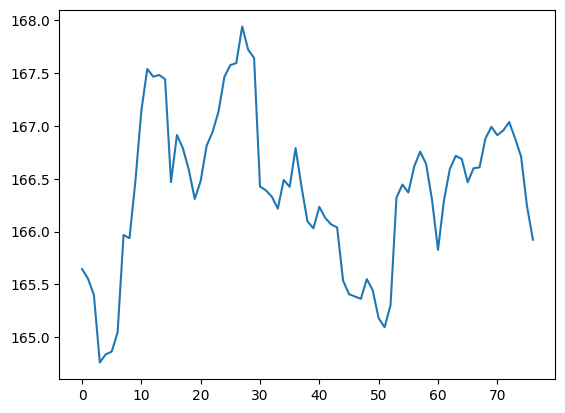

In [ ]:
# getting angle data from the videos
# 5-16 ska loopas igenom 
'''
angles: 
    - shoulder angle (elbow, shoulder, hip) --> r: 8,6,12    l: 7,5,11
    - hip (shoulder, hip, knee)             --> r: 6,12,14   l: 5,11,13
    - knee (hip,knee,ankle)                 --> r: 12,14,16  l: 11,13,16
'''
num_of_angles = 3 * 2 # three joint angles for right and left side 

(num_samples,seq_length, points) = X_body.shape
print( num_samples,seq_length, points )
angle_data = np.zeros((num_samples,seq_length,num_of_angles))

joint_indexes = ([7,5,11],[8,6,12],[5,11,13],[6,12,14],[11,13,16],[12,14,16])
test = X_body[0]
print(test.shape)

for idx,sample in enumerate(X_body):
    for joint in joint_indexes:
        j1 = joint[0] -5
        j2 = joint[1] -5 
        j3 = joint[2] -5

        reshaped_sample = sample.reshape(seq_length, int(points/2), 2)

        joint_angles = get_joint_angle(reshaped_sample,j1,j2,j3)

        angle_data[idx] = joint_angles


print(angle_data.shape)

test_plot_data = angle_data[0]
test = test_plot_data[:,0]
print(test)
plt.plot(test)




In [47]:
def compute_velocity(position):
    '''
    input
        position: np array shape (n_frames, 2) where position[i] = (x,y) in pixels
    output
        velocity: np array shape (n_frames, 2) where velocity[i] = (x,y) in pixels/frame
    '''
    position_float = position.astype(float)
    displacement = np.diff(position_float, axis=0)
    velocity = displacement /1  # Assuming each frame is one time unit
    return velocity



#getting velocity from the points

(num_videos,seq_length, points) = X_body.shape
vel_all = np.zeros((num_videos,seq_length-1,int(points/2),2))

for idx,video in enumerate(X_body):
    reshaped_sample = video.reshape(seq_length, int(points/2), 2)
    vel_video = np.zeros((seq_length-1,int(points/2),2))

    for i in range(reshaped_sample.shape[1]):
        sample = reshaped_sample[:, i, :] 
        velocity = compute_velocity(sample)
        vel_video[:, i, :] = velocity
    
    vel_all[idx] = vel_video






In [ ]:
# keypoints_frame = keypoints from one frame 
keypoints_frame = 0
knee_angle_yolo_l = get_joint_angle(keypoints_frame,15, 13,11,13)
knee_angle_yolo_r = get_joint_angle(keypoints_frame,16,14,12,14)
hip_angle_yolo_l = get_joint_angle(keypoints_frame,13,11,5,11)
hip_angle_yolo_r = get_joint_angle(keypoints_frame,14,12,6,12)
arm_leg_angle_yolo_l = get_joint_angle(keypoints_frame,9,5,15,11)
arm_leg_angle_yolo_r = get_joint_angle(keypoints_frame,10,6,16,12)

## Results and Discussion

In [ ]:
# Always use comments in the code to document specific steps

This section should contain:
- Results.
- Summary of best model performance:
    - Name of best model file as saved in /models.
    - Relevant scores such as: accuracy, precision, recall, F1-score, etc.
- Key discussion points.